# The COVIDNetX challenge

<img src="https://www.psycharchives.org/retrieve/096175aa-f7f2-4970-989d-d934c30b5551" alt="drawing" width="400"/>

The following is a classification challenge using the [COVID-X dataset](https://github.com/lindawangg/COVID-Net/blob/master/docs/COVIDx.md).
The goal is to predict whether a person has COVID-19 or not based on chest X-RAY images.

There are two different categories: `positive` and `negative`. `positive` means a person has COVID-19, `negative` means a person
has not COVID-19.

The metric we use is F1 (https://en.wikipedia.org/wiki/F1_score). The goal is to maximize F1.

The data contains images with their associated labels.

## EDA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

In [2]:
data_dir = 'data/'
# data_dir = 'data_subset/'

df = pd.read_csv(data_dir+'train.csv')

In [3]:
df.sample(10)

,image,label
153,f2e1556727f55fa83bbcade4533299e9.png,negative
491,45674eb60936d084e3381e5e6761707d.png,negative
9655,f68405df9f517f847b2966be5489638a.png,positive
5436,1761cdbf3873edc78122baa65178f105.png,negative
9000,ad1ccb34a1cf5bb34e7930033c3887d5.png,negative
2212,961ad220af0bd7452764073adf13c9f3.png,negative
11384,862782a3ba55854faf921bb90f43333f.png,negative
7917,95d6a0a56c23d4c6f35c215a197549ae.png,negative
5417,44b3148a149489a26d3eb6a3d7486913.png,negative
9581,71fc4c22f325aaee14dc37a27f9763df.png,negative


negative    0.8915
positive    0.1085
Name: label, dtype: float64

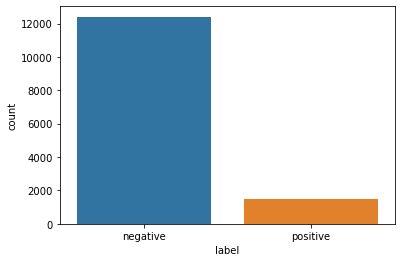

In [4]:
sns.countplot(data=df, x='label');
(df.label.value_counts())/len(df)

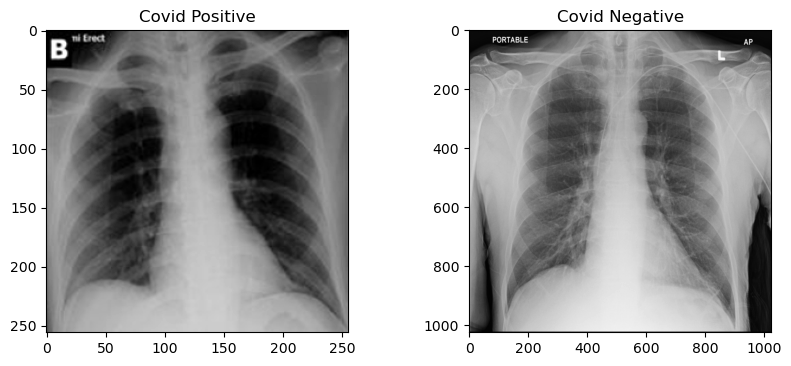

In [5]:
covid_pos = mpimg.imread(data_dir+'train/69f8f0947e784ae04984a5947f90b4a1.png')
covid_neg = mpimg.imread(data_dir+'train/3c4debafc8e6c1fea2b24822279c326f.png')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4), dpi=100)

ax[0].imshow(covid_pos, cmap='gray')
ax[0].set_title('Covid Positive')
ax[1].imshow(covid_neg, cmap='gray')
ax[1].set_title('Covid Negative');

## Data Preprocessing

In [6]:
from sklearn.model_selection import train_test_split

# train_df, valid_df = train_test_split(df.sample(300, random_state=42), test_size=0.2, random_state=42)
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)
valid_df, test_df = train_test_split(valid_df, test_size=0.5, random_state=42)

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = 256
batch_size = 64

datagen = ImageDataGenerator(
    rescale=1./255, 
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    )

train_datagen = datagen.flow_from_dataframe(
    train_df, 
    data_dir+'train/', 
    target_size=(img_size,img_size), 
    x_col='image', 
    y_col='label', 
    batch_size=batch_size, 
    class_mode='binary',
    seed=42,
    shuffle=True)

valid_datagen = datagen.flow_from_dataframe(
    valid_df, 
    data_dir+'train/', 
    target_size=(img_size,img_size), 
    x_col='image', 
    y_col='label', 
    batch_size=batch_size, 
    class_mode='binary',
    seed=42,
    shuffle=True)

datagen_rescale = ImageDataGenerator(rescale=1./255)
test_datagen = datagen_rescale.flow_from_dataframe(
    test_df, 
    data_dir+'train/', 
    target_size=(img_size,img_size), 
    x_col='image', 
    y_col='label', 
    batch_size=batch_size, 
    class_mode='binary',
    seed=42,
    shuffle=True)

2021-09-27 02:19:53.135508: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Found 11133 validated image filenames belonging to 2 classes.
Found 1392 validated image filenames belonging to 2 classes.
Found 1392 validated image filenames belonging to 2 classes.


In [8]:
train_datagen.class_indices

{'negative': 0, 'positive': 1}

## CNN Model

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization
from tensorflow.keras import callbacks

cnn = Sequential()
cnn.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(img_size,img_size,3)))

cnn.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
cnn.add(MaxPool2D())
cnn.add(BatchNormalization())
cnn.add(Dropout(rate=0.25))

cnn.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
cnn.add(MaxPool2D())
cnn.add(BatchNormalization())
cnn.add(Dropout(rate=0.25))

cnn.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
cnn.add(MaxPool2D())
cnn.add(BatchNormalization())
cnn.add(Dropout(rate=0.25))

cnn.add(Flatten())

cnn.add(Dense(units=512, activation='relu'))
cnn.add(BatchNormalization())
cnn.add(Dropout(rate=0.25))

cnn.add(Dense(units=256, activation='relu'))
cnn.add(BatchNormalization())
cnn.add(Dropout(rate=0.25))

cnn.add(Dense(units=128, activation='relu'))
cnn.add(BatchNormalization())
cnn.add(Dropout(rate=0.25))

cnn.add(Dense(units=1, activation='sigmoid'))

cnn.compile(loss=tf.keras.losses.binary_crossentropy, optimizer='adam', metrics=['acc'])
cnn.summary()

2021-09-27 02:20:03.131413: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-27 02:20:03.137715: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-27 02:20:03.195153: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:03:00.0 name: Tesla K40m computeCapability: 3.5
coreClock: 0.745GHz coreCount: 15 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 268.58GiB/s
2021-09-27 02:20:03.196373: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:83:00.0 name: Tesla K40m computeCapability: 3.5
coreClock: 0.745GHz coreCount: 15 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 268.58GiB/s
2021-09-27 02:20:03.196453: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-09-27 02:20:03.380

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 252, 252, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 64)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 64)      256       
_________________________________________________________________
dropout (Dropout)            (None, 126, 126, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 128)       0

In [10]:
%%time

checkpoint_cb = callbacks.ModelCheckpoint("cnn_basic.h5", save_best_only=True)

history = cnn.fit(
    train_datagen, 
    steps_per_epoch=len(train_datagen), 
    epochs=100,
    validation_data=valid_datagen,
    validation_steps=len(valid_datagen),
    callbacks=[checkpoint_cb])

2021-09-27 02:20:09.929953: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-27 02:20:09.930805: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499900000 Hz


Epoch 1/100


2021-09-27 02:20:12.045216: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-09-27 02:20:14.814460: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2021-09-27 02:20:16.580649: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2021-09-27 02:20:16.638091: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


174/174 [==============================] - 588s 3s/step - loss: 0.6388 - acc: 0.6977 - val_loss: 0.8954 - val_acc: 0.4346
Epoch 2/100
174/174 [==============================] - 403s 2s/step - loss: 0.2935 - acc: 0.8967 - val_loss: 0.3583 - val_acc: 0.8585
Epoch 3/100
174/174 [==============================] - 406s 2s/step - loss: 0.2389 - acc: 0.9126 - val_loss: 0.3156 - val_acc: 0.8534
Epoch 4/100
174/174 [==============================] - 404s 2s/step - loss: 0.2132 - acc: 0.9207 - val_loss: 2.8911 - val_acc: 0.3190
Epoch 5/100
174/174 [==============================] - 399s 2s/step - loss: 0.2034 - acc: 0.9232 - val_loss: 0.1802 - val_acc: 0.9282
Epoch 6/100
174/174 [==============================] - 398s 2s/step - loss: 0.1700 - acc: 0.9389 - val_loss: 0.2629 - val_acc: 0.8858
Epoch 7/100
174/174 [==============================] - 402s 2s/step - loss: 0.1747 - acc: 0.9332 - val_loss: 0.1914 - val_acc: 0.9339
Epoch 8/100
174/174 [==============================] - 404s 2s/step - loss

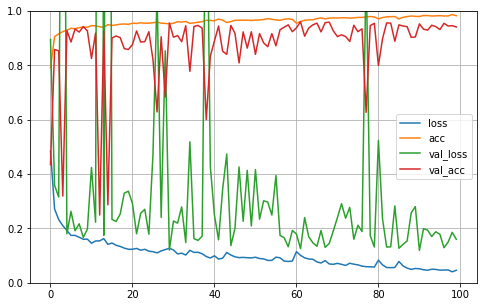

In [11]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [12]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = cnn.predict(test_datagen, steps=len(test_datagen), verbose=1) > 0.5
y_true = valid_df.label.map(test_datagen.class_indices)

22/22 [==============================] - 33s 2s/step


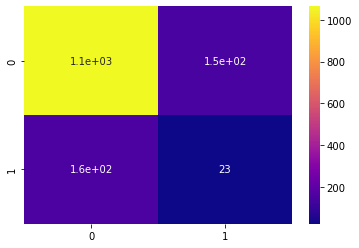

In [13]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, cmap='plasma', annot=True);

In [17]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.88      0.88      1213
           1       0.13      0.13      0.13       179

    accuracy                           0.78      1392
   macro avg       0.50      0.50      0.50      1392
weighted avg       0.78      0.78      0.78      1392

